# Import

In [1]:
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np

# Import necessary libraries
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
import seaborn as sns

import openml
import tensorflow as tf
import gpflow
from gpflow.kernels import Kernel
from gpflow.utilities import positive

In [2]:
mnist = loadmat("mnist-original.mat")
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]

# # Reshape MNIST data
# mnist_data = mnist_data.reshape(mnist_data.shape[0], 28, 28)

# # Convert mnist_label to int
# mnist_label = mnist_label.astype(int)

print(mnist_data.shape)

(70000, 784)


In [3]:
# # Count the number of each digit
# count = [0] * 10
# for i in range(len(mnist_label)):
#     count[mnist_label[i]] += 1
# print(count)

In [4]:
# Select MNIST 0 and 1
mnist_0 = mnist_data[mnist_label == 0][0:40]
mnist_1 = mnist_data[mnist_label == 1][0:40]

0.0


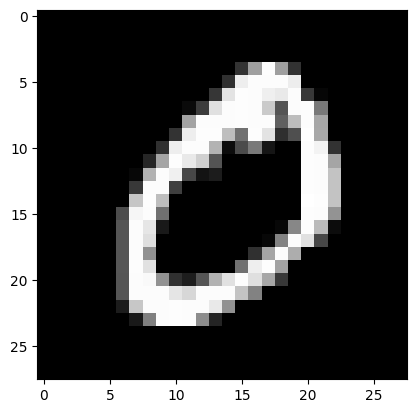

In [5]:
# Show the first image
first_image = mnist_data[0]

print(mnist_label[0])
first_image = np.array(first_image, dtype='float')
pixels = first_image.reshape((28, 28))
plt.imshow(pixels, cmap='gray')
plt.show()

# Invariant Convolution

In [6]:
def invariant_convolutional(input, patch_size):
    # Get the dimensions of the input
    input_shape = input.shape
    input_height = input_shape[0]
    input_width = input_shape[1]
    # input_channels = input_shape[2]

    # Get the dimensions of the patch
    patch_height = patch_size[0]
    patch_width = patch_size[1]

    # Initialize the output feature map
    output = np.zeros((input_height - patch_height + 1, input_width - patch_width + 1))

    # Perform the invariant convolution operation
    for i in range(input_height - patch_height + 1):
        for j in range(input_width - patch_width + 1):
            patch = input[i:i+patch_height, j:j+patch_width, :]
            output[i, j] = np.sum(patch)

    return output

(26, 26)


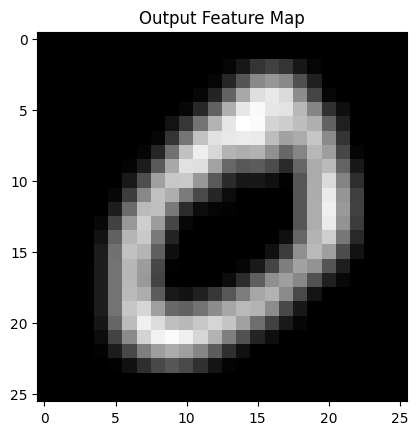

In [7]:
# Try on mnist_data
patch_size = (3, 3)
output = invariant_convolutional(mnist_data[0].reshape(28, 28, 1), patch_size)
print(output.shape)

# Plot the output feature map
plt.imshow(output, cmap='gray')
plt.title('Output Feature Map')
plt.show()

# Classification

In [8]:
X = np.vstack((mnist_0, mnist_1))
y = [0] * len(mnist_0) + [1] * len(mnist_1)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=50)

In [9]:
# Standardize the features
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_test_standardized = scaler.transform(X_test)

In [10]:
# Define the kernel
kernel = 1.0 * RBF(length_scale=1.0)  # RBF kernel with default parameters

In [11]:
# Create the Gaussian process classifier
gp = GaussianProcessClassifier(kernel=kernel)

# Fit the model to the training data
gp.fit(X_train_standardized, y_train)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [12]:
# Make predictions on the test data
y_pred = gp.predict(X_test_standardized)

In [13]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

1.0


# Convolutional Classification GP

In [14]:
# Perform invariant convolution on the selected samples
patch_size = (5, 5)
X_train_conv = np.array([invariant_convolutional(sample.reshape(28, 28, 1), patch_size).flatten() for sample in X_train])
X_test_conv = np.array([invariant_convolutional(sample.reshape(28, 28, 1), patch_size).flatten() for sample in X_test])

print(X_train_conv.shape)

# Standardize the features
scaler = StandardScaler()
X_train_conv_standardized = scaler.fit_transform(X_train_conv)
X_test_conv_standardized = scaler.transform(X_test_conv)

# Define the kernel
kernel = 1.0 * RBF(length_scale=1.0)  # RBF kernel with default parameters

(40, 576)


In [15]:
# Create the Gaussian process classifier
gp = GaussianProcessClassifier(kernel=kernel)

# Fit the model to the training data
gp.fit(X_train_conv_standardized, y_train)

GaussianProcessClassifier(kernel=1**2 * RBF(length_scale=1))

In [16]:
# Make predictions on the test data
y_pred = gp.predict(X_test_conv_standardized)

In [17]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

1.0


# Weighted Convolution

In [30]:
tf.keras.backend.set_floatx('float32')
gpflow.config.set_default_float(tf.float32)

In [31]:
class Conv(Kernel):
    def __init__(self, basekern, img_size, patch_size, colour_channels=1):
        super().__init__()
        
        self.img_size = img_size
        self.patch_size = patch_size
        self.basekern = basekern
        self.colour_channels = colour_channels
        
        self.num_patches = ((self.img_size[0]- self.patch_size[0] + 1) *(self.img_size[1]- self.patch_size[1] + 1) *colour_channels)
        
        self.basekern.active_dims = slice(0, np.prod(patch_size)* colour_channels)
        
    def _reshape_X(self, X):
        return tf.reshape(X, (-1, self.img_size[0], self.img_size[1], self.colour_channels))
    
    def _extract_patches(self, X):
        X_reshaped = self._reshape_X(X)
        patches = tf.image.extract_patches(images=X_reshaped,sizes=[1, self.patch_size[0], self.patch_size[1], 1], strides=[1, 1, 1, 1],rates=[1, 1, 1, 1], padding="VALID")

        patch_dim = self.patch_size[0] * self.patch_size[1] *self.colour_channels
        return tf.reshape(patches, [-1, self.num_patches,patch_dim])
    
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
            
        patches_X = self._extract_patches(X)
        patches_X2 = self._extract_patches(X2)
        
        patches_X_flat = tf.reshape(patches_X, [-1, tf.shape(patches_X)[-1]])
        patches_X2_flat = tf.reshape(patches_X2, [-1, tf.shape(patches_X2)[-1]])
        
        K_matrix = self.basekern.K(patches_X_flat, patches_X2_flat)
        
        K_matrix_reshaped = tf.reshape(K_matrix, [tf.shape(X)[0],self.num_patches, tf.shape(X2)[0], self.num_patches])
         
        return tf.reduce_sum(K_matrix_reshaped, axis=[1, 3]) / (self.num_patches ** 2)
    
    
    def K_diag(self, X):
        patches_X = self._extract_patches(X)
        patches_X_flat = tf.reshape(patches_X, [-1, tf.shape(patches_X)[-1]])
        
        K_diag = self.basekern.K_diag(patches_X_flat)
        
        return tf.reduce_sum(tf.reshape(K_diag, [tf.shape(X)[0], self.num_patches]), axis=1) / self.num_patches

In [32]:
print(X_train_standardized.shape)

(40, 784)


In [33]:
y_train_np = np.array(y_train).reshape(-1, 1)
X_train_stand_tf = tf.convert_to_tensor(X_train_standardized, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train_np, dtype=tf.float32)

In [34]:
base_kernel = gpflow.kernels.SquaredExponential()
conv_kernel = Conv(basekern=base_kernel, img_size=(28, 28), patch_size=(3, 3))

y_train_np = np.array(y_train).reshape(-1, 1)
model = gpflow.models.GPR(data=(X_train_stand_tf, y_train_tf), kernel=conv_kernel, mean_function=None)

opt = gpflow.optimizers.Scipy()
opt_logs = opt.minimize(model.training_loss, model.trainable_variables, options=dict(maxiter=100))

In [35]:
y_test_np = np.array(y_test).reshape(-1, 1)
X_test_stand_tf = tf.convert_to_tensor(X_test_standardized, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test_np, dtype=tf.float32)

In [36]:
mean, var = model.predict_y(X_test_stand_tf)
pred_labels = np.round(mean.numpy()).astype(int)

In [37]:
accuracy = accuracy_score(y_test, pred_labels)
print(accuracy)

0.975


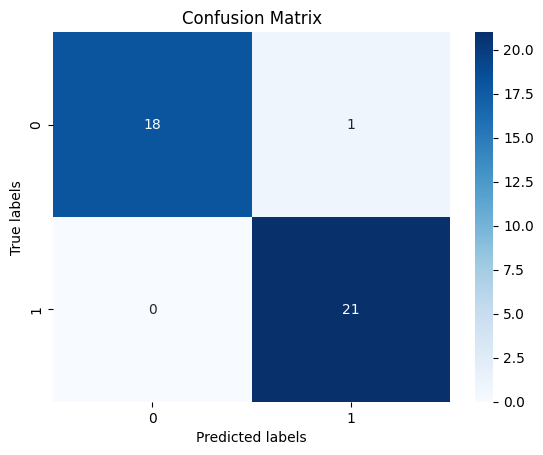

In [38]:
# Show confusion matrix
cm = confusion_matrix(y_test, pred_labels)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [55]:
# Convert mean to numpy array
mean_np = mean.numpy()
mean_np = mean_np.reshape(int(mean.shape[0]), 1)
mean_np = mean_np.flatten()

array([ 1.02502298e+00, -7.03531504e-02,  9.52909708e-01,  5.85310519e-01,
        3.59300002e-02,  9.98869538e-01,  1.02697098e+00,  4.48514521e-03,
        7.95837957e-04,  8.75403062e-02,  9.27167416e-01,  1.01775610e+00,
        1.03824461e+00,  2.97390074e-02, -6.11392744e-02,  9.37557757e-01,
        1.05633926e+00,  1.34782925e-01,  1.10798523e-01,  1.00851834e+00,
        9.51587558e-01,  1.03694773e+00,  1.08403254e+00,  3.67153510e-02,
       -6.24985807e-02, -8.57577771e-02,  1.01009846e+00,  1.05492616e+00,
        1.02625513e+00,  3.17466617e-01, -5.24927229e-02, -5.57086170e-02,
        1.14748895e-01,  1.26606122e-01,  4.60588008e-01,  5.20057917e-01,
        1.02035832e+00,  1.01357317e+00,  1.00373852e+00,  1.03230989e+00],
      dtype=float32)

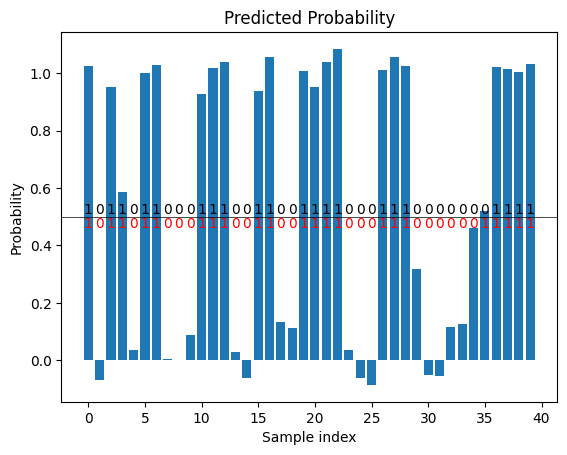

In [62]:
# Show bar plot of the probabilities
plt.bar(range(len(mean_np)), mean_np)

# Label the correct class 
for i in range(len(y_test)):
    if y_test[i] == 0:
        plt.text(i, 0.5, '0', ha='center', va='bottom')
    else:
        plt.text(i, 0.5, '1', ha='center', va='bottom')
        
# Label the predicted class using red text
for i in range(len(y_test)):
    if pred_labels[i] == 0:
        plt.text(i, 0.5, '0', ha='center', va='top', color='red')
    else:
        plt.text(i, 0.5, '1', ha='center', va='top', color='red')
        
# Draw a line at probability 0.5
plt.axhline(y=0.5, color='black', linewidth=0.5)
        
plt.xlabel('Sample index')
plt.ylabel('Probability')
plt.title('Predicted Probability')
plt.show()
